mainly looking at https://github.com/ngessert/isic2019/blob/master/models.py

# start

In [3]:
PRFX = 'Mel0626A1'

SEED = 101
ARCH = 'efficientnet-b0'
SZ = 128
EPOCHS = 10

FP16 = True
DEBUG = False
if DEBUG: EPOCHS=1
DEVICE = 'cpu'; PIN_MEM = (DEVICE=='cuda')

# setup

In [4]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from efficientnet_pytorch import EfficientNet

from apex import amp

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

set_seed(SEED)

In [11]:
p_cmp = '../input/siim-isic-melanoma-classification'
p_19 = '../input/andrewmvd--isic-2019'
# p_out=f'../output/{PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)

train,test,sample_submission = (pd.read_csv(o) for o in [f'{p_cmp}/{o}.csv' 
                                                         for o in ('train', 'test', 'sample_submission')])
print([o.shape for o in (train,test,sample_submission)])

train19 = pd.read_csv(f'{p_19}/ISIC_2019_Training_GroundTruth.csv')
print(train19.shape)

display(train19.head(2))
display(train.head(2))

test.head(2)

[(33126, 8), (10982, 5), (10982, 2)]
(25331, 10)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity


# prep

In [38]:
train['source'] = '20'
train['im_pth'] = f'{p_cmp}/jpeg/train/'+train.image_name+'.jpg'
train19['source'] = '19'
train19['target'] = train19.MEL
train19['im_pth'] = f'{p_19}/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+train19.image+'.jpg'


In [39]:
cols2use=['source', 'im_pth', 'target', ]
train_all = pd.concat([train[cols2use], train19[cols2use]])
display(train_all.shape)
display(train_all.source.value_counts())
display(train_all.groupby('source').target.mean())

(58457, 3)

20    33126
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017630
Name: target, dtype: float64

In [40]:
train_all.im_pth.values[i]

'../input/siim-isic-melanoma-classification/jpeg/train/ISIC_5467082.jpg'

CPU times: user 14.4 ms, sys: 88 µs, total: 14.5 ms
Wall time: 24.3 ms


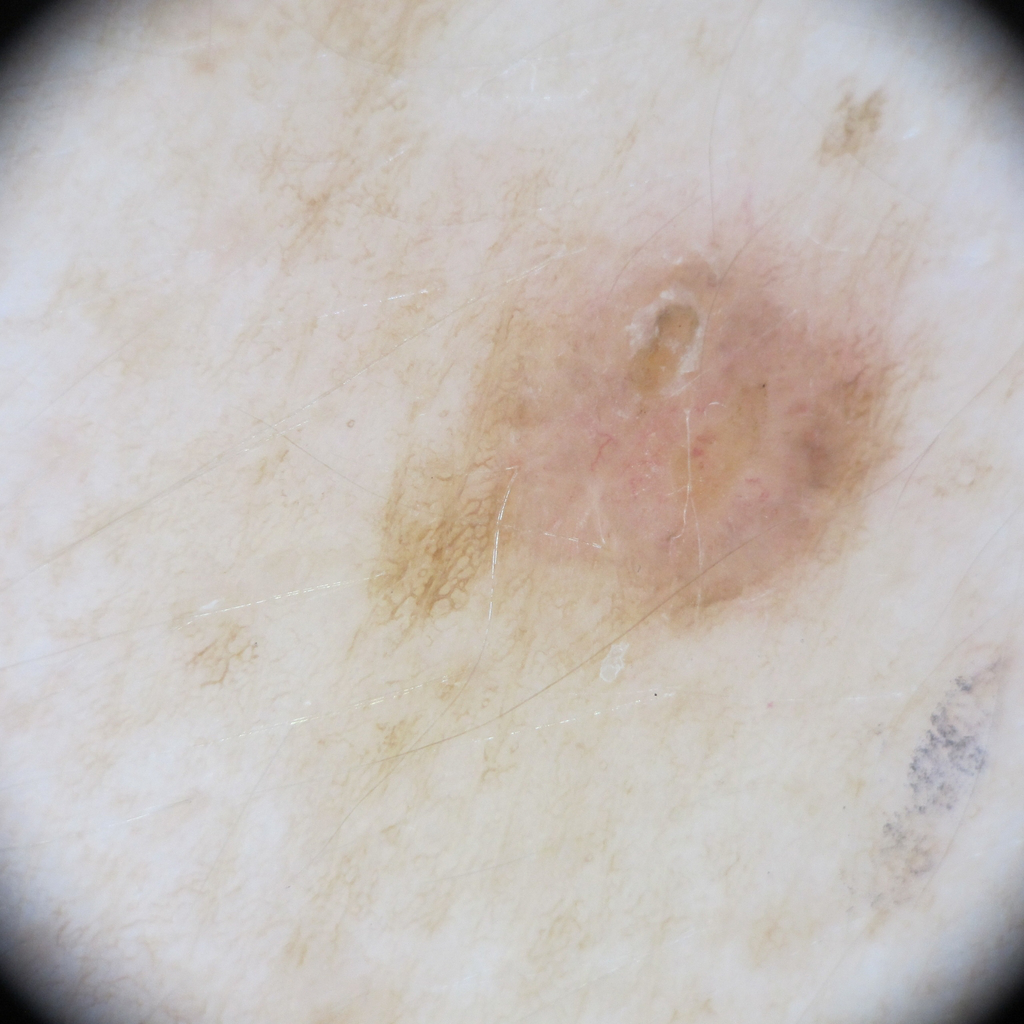

In [57]:
%%time
i=np.random.choice(range(len(train_all)))
fnm=train_all.im_pth.values[i]
img_pil = Image.open(fnm)
img_pil

In [ ]:
lst_im_pil

# dataset

In [10]:
# melanoma-pytorch-starter-efficientnet
class MelDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imgs, train: bool = True, transforms = None, meta_features = None):
        self.df = df
        self.imgs = imgs
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        x = self.imgs[i]
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)    

# ds_train = MelDataset(train, imgs_train, meta_features=metafeats)

# transforms

In [11]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std =[0.229, 0.224, 0.225])

In [12]:
tsfms = transforms.Compose([
            transforms.ToTensor(),
            normalize,
])

# Model

In [13]:
arch = EfficientNet.from_pretrained(ARCH)

Loaded pretrained weights for efficientnet-b0


In [14]:
arch

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [15]:
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        self.meta = nn.ModuleList([nn.Linear(n_meta_features, 256),
                                  nn.BatchNorm1d(256),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.4),
                                  nn.Linear(256, 256),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(256),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.4)])
        self.output = nn.ModuleList(
            [nn.Linear(1280 + 256, 512),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 1)]
        )
        
    def forward(self, inputs):
        x_img, x_meta = inputs
        cnn_feats= self.arch(x_img)
        meta_feats = self.meta(x_meta)
        x = torch.cat((cnn_feats, meta_feats), dim=1)
        x = self.ouput(x)
        return x

In [16]:
net = Net(arch, len(metafeats))

In [17]:
imgs_train = imgs_train.transpose(0,3,1,2)
ds_train = MelDataset(train, imgs_train, transforms=tsfms, meta_features=metafeats)

In [18]:
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=7, shuffle=True, num_workers=4
)


In [27]:
ds_train[3]

RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 0

In [20]:
for dat in dl_train:
    x,y=dat; break

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-10-5cf2a2b4b641>", line 15, in __getitem__
    x = self.transforms(x)
  File "/data/anaconda3/envs/mel/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 70, in __call__
    img = t(img)
  File "/data/anaconda3/envs/mel/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 175, in __call__
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/data/anaconda3/envs/mel/lib/python3.7/site-packages/torchvision/transforms/functional.py", line 218, in normalize
    tensor.sub_(mean[:, None, None]).div_(std[:, None, None])
RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 0


In [41]:
%debug

> /data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/modules/module.py(96)forward()
     94             registered hooks while the latter silently ignores them.
     95         """
---> 96         raise NotImplementedError
     97 
     98     def register_buffer(self, name, tensor):

ipdb> q


# train

In [100]:
epochs = EPOCHS